In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
#import segyio
#import segysak
import itertools
import scipy.ndimage
import pandas as pd
from mayavi import mlab
import pathlib
import netCDF4

QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


## Practical 3 - Visualising full-stack 3D seismic reflection data


In this exercise you are simulating a "zero-offset" seismic experiment where sources and receivers are located at the same place just below the Earth's surface so you are only dealing with "normal-incidence" reflections. 

At the end of the exercise there is an extension activity to load some SEG-Y data that are partially incomplete. You will NOT be asked to do this in an assessment, but if you download your own SEG-Y data you may have to apply these steps to get it loaded correctly. 

**If you have time see [Bonus](./Ex3_Bonus.ipynb) excercise.**

**Learning objectives**:
1) understand how fully processed seismic data is stored and how to access this within python
2) Understand the important headers for plotting data
3) Learn how to plot data in different ways (wiggle traces, variable density, colour scales, etc.)

## 3.1 - Using segy data volumes

In this section you are provided with a perfect data cube, this means that the dataset has no missing points and it is structured in such a way that the segyio library can deal with reading in this file without the user requiring to adjust the dataset. In this activity we are using ["segyio"](https://segyio.readthedocs.io/en/latest/) to read the data into a numpy array, however, there are other tools available to do this. 


<div class="alert alert-block alert-danger">
There may be a problem with segyio installation on Mac M1 and M2, for your convinience we have changed the SEGY format to netcdf. It is a great opportyunity to deal with the real world problem and use of various format for your purpose. 

We are going to start with dataset TNW_small2. This is a sub-cube from a larger 3D data volume. As we discussed in the lecture it is from offshore the Netherlands and is located in a region of planned wind farm activities. The dataset has been collected with a sparker source and has been post-stack depth migrated. It images from 47.05 m below the seabed to 92.05 m. 

In [3]:
#V3D_path = pathlib.Path("data/TNW_small2")
#print("3D", V3D_path, V3D_path.exists())
#from segysak.segy import get_segy_texthead
#get_segy_texthead('data/TNW_small2')
#from segysak.segy import segy_header_scan
#scan = segy_header_scan(V3D_path)
#scan
#from segysak.segy import segy_loader, well_known_byte_locs
#V3D = segy_loader(V3D_path)
#V3D.seisio.to_netcdf("V3D.SEISNC")


**Exercise1: Have a careful read  through the EBCDIC header and try to recognise some of the terms we have learned about in the lecture. How many inlines are there? Can you identify in the EBCDIC where the depth range is give (does anything surprise you about this)?**

In [4]:
base = netCDF4.Dataset('data/V3D.SEISNC')
base.variables.keys()
depth = np.array(base.variables['twt'][:])
inlines = np.array(base.variables['iline'][:])
xlines = np.array(base.variables['xline'][:])
data = np.array(base.variables['data'][:])


FileNotFoundError: [Errno 2] No such file or directory: b'data/V3D.SEISNC'

In [6]:
print (xlines.size) # inline numbers
print (inlines.size) # xline numbers
print (depth.size) # time/depth samples
print (data.shape) # data in 3d array

524
572
450
(572, 524, 450)


<details>
    <summary>💡 Answer</summary>
There are 572 inlines and 524 xlines. The depth range is labelled as
Time min: -92.05 max: -47.05  
for some reason. We think this might be a mistake when the EBCDIC was written as this should be depth rather than time**

Note: even though data cube indexing first position is 0,0,0 it doesn’t mean this is how they are labelled in the field data files! In our case this is for instance because we are only using a part of the datacube that happens to start on inline 2000 

If the SEG-Y data is rectangular, perfectly structured and is not missing any data we can directly extract the below attributes from the dataset without any further work. We will see an example of a non-perfectly structured dataset at the end (ST020.segy) and how we recover this information in this case. In an assessment you will be given a perfectly structured cube- however, if you download your own data from a repository online you may encounter some imperfect data!

## 3.2 - visualising data volumes 
In this section we will focus on visualising a perfect data volume.


### 3.2.1 3D visualisation
The python library [`mayavi`]((https://towardsdatascience.com/visualizing-3d-seismic-volumes-made-easy-with-python-and-mayavi-e0ca3fd61e43)) is a great and efficient 3D visualisation tool that we will be using to visualise our seismic data volumes.

In [7]:
def explore3d(data_cube, preset = True, I=-1, X = -1 , Z=-1):
    """
    
    """
    source = mlab.pipeline.scalar_field(data_cube)
    source.spacing = [1, 1, -1]
    vm = np.percentile(data_cube, 95) #may need to play a little with the 95
    
    if preset == True:
        nx, ny, nz = data_cube.shape
        I = nx//2
        X = ny//2
        Z = nz//2

    mlab.pipeline.image_plane_widget(source, plane_orientation='x_axes', 
                                     slice_index=I, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source, plane_orientation='y_axes', 
                                     slice_index=X, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source, plane_orientation='z_axes', 
                                     slice_index=Z, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.show()

In [9]:
# geological features of interest at these locations
I = np.where(inlines == 2285)[0][0]
X = np.where (xlines == 1578)[0][0]
Z = np.where(np.isclose(depth, 60))[0][0]

explore3d(data, preset = False, I = I, X = X, Z = Z)

D3D12: Removing Device.


### 3.2.2 dynamic range

**Exercise2: Try to visualize your data for inline = 2200** 

Hint: you need to define a boundary in which the x would be your crossline (`xlines[0]`, `xlines[-1]`) and the y would be the depth (`depth[0]`, `depth[-1]`)**

Reminder: `np.where` would help you to find the inline index

Text(0, 0.5, 'Depth (m)')

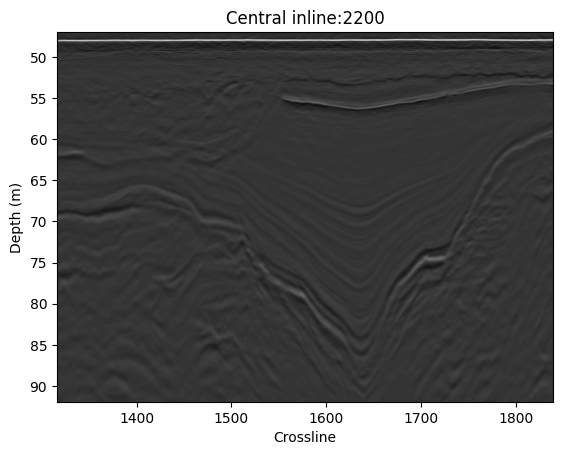

In [10]:
boundary = [xlines[0], xlines[-1],depth[-1], depth[0]]
inline =  data[np.where(inlines == 2200)[0][0],:,:] ## you can change the inline to s
plt.imshow(inline.T,extent = boundary, cmap='gray', aspect='auto')

plt.title('Central inline:' + str(inlines[np.where(inlines == 2200)[0][0]]))
plt.xlabel('Crossline')
plt.ylabel('Depth (m)')


**dynamic range**  -> the range of total difference between the lightest light and darkest dark of an image

In our plots above we are limited by an 8-bit image representation, we can visualise 256 shades. For this to work our wide spread of amplitudes needs to be compressed into these 256 shades. However having large outliers will jeperdise having a good dynamic range. To solve this we can clip outliers so we can use our available dynamic range better. 

Text(0, 0.5, 'Depth (m)')

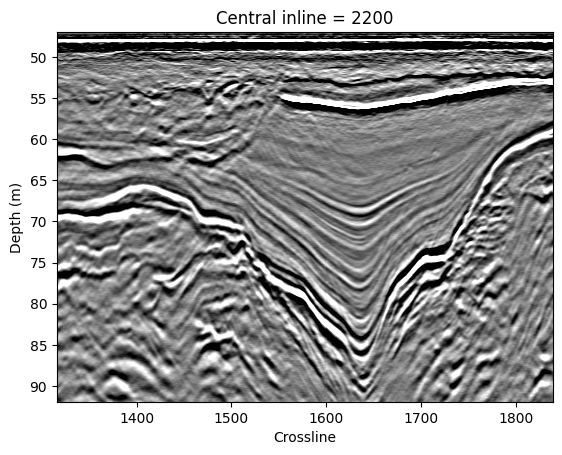

In [11]:
vm = np.percentile(data, 95)
boundary = [xlines[0], xlines[-1],depth[-1], depth[0]]
inline =  data[np.where(inlines == 2200)[0][0],:,:] ## you can change the inline to s
plt.imshow(inline.T,extent = boundary, cmap='gray', aspect='auto',vmin=-vm, vmax=vm)

plt.title('Central inline = ' + str(inlines[np.where(inlines == 2200)[0][0]]))
plt.xlabel('Crossline')
plt.ylabel('Depth (m)')

## 3.2.3 plot inlines/crosslines/timeslices

**Exercise3: Try to visualize your data for xline = 1600 and depth = 70** 

Hint: make sure you have a good dynamic range. Further play with other colormaps, we This time let's try `cmap = seismic`



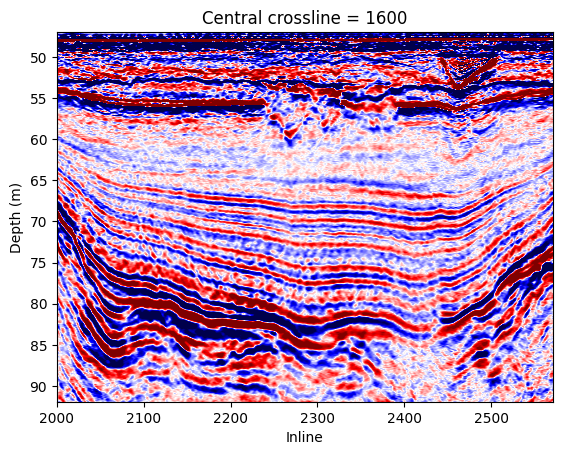

In [12]:
# Plot crossline = 1600
boundary = [inlines[0], inlines[-1], depth[-1], depth[0]]
xline =  data[:,np.where(xlines == 1600)[0][0],:] 
plt.imshow(xline.T,extent = boundary, cmap='seismic', aspect='auto',vmin=-vm, vmax=vm)

plt.title('Central crossline = ' + str(xlines[np.where(xlines == 1600)[0][0]]))
plt.xlabel('Inline')
plt.ylabel('Depth (m)')
plt.show()

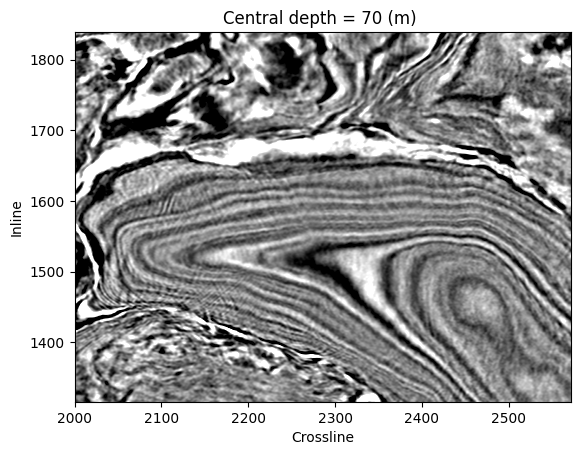

In [13]:
# Plot depth = 70
boundary = [inlines[0], inlines[-1], xlines[0], xlines[-1]]
depths =  data[:,:,np.where(np.isclose(depth, 70))[0][0]] 
plt.imshow(depths.T,extent = boundary, cmap='gray', aspect='auto',vmin=-vm, vmax=vm)

plt.xlabel('index number, proportional to depth')
plt.title('Central depth = 70 (m) ')
plt.xlabel('Crossline')
plt.ylabel('Inline')
plt.show()


**Exercise4: Explore the other rest of the dataset for yourself in 3D. Can you find any examples of the following geological features? If you can, give the inline/xlines numbers or depth and provide an image:**

- Glacial Channel
- possible river channel
- mass transport deposit
- faults?

# 3.3 - reading in non-ideal datasets

In this section you will load the ST0202.segy dataset from the Volve field, North Sea. This dataset is not structured as nicely as TNW_small2 so you will need to do a bit more work to load it. 

- Now that our dataset is unstructure we do not have access anymore to the previously given dataset attributes, we can however work around this

- you will not be given an non-ideal dataset to process in the assessment, but we aware of the potential struggles of using non-ideal datasets if you download your own data from open source repositories. 


In [14]:
#base_segy2 = 'data/ST0202.segy'

In [15]:
#base_segy2 = segyio.open(base_segy2, ignore_geometry= True) #opens files like python default open call , assumes a well-structured 3D volume, 

Now that our dataset is unstructured we do not have access anymore to the automatically given dataset attributes, we can however work around this and fix our dataset

In [76]:
#inlines = []
#crosslines = []
#for h in base_segy2.header:
#    inlines.append(h[segyio.su.iline])
#    crosslines.append(h[segyio.su.xline])

In [77]:
#plt.scatter(crosslines, inlines, marker="s", s=1)

If you look very closely you can see there are travces missing in the left bottom and right bottom corner! 

Lets try to understand what is missing

In [78]:
#uniqil = set(inlines)
#uniqxl = set(crosslines)
#real = set(zip(inlines, crosslines)) #set removes duplicates, works same as sets from maths
#grid = set(itertools.product(uniqil, uniqxl))
#missing = grid - real
#print (missing)

Lets fill out the missing traces and create a regular volume. 

In [79]:
#ils = np.unique(inlines)
#xls = np.unique(crosslines)
#inline_interval    = ils[1:] - ils[:-1]
#crossline_interval = xls[1:] - xls[:-1]


We now need to put every trace in the right place, which means we need to map in/crossline pairs to the right offset in our target array. Had no traces been missing, this is what segyio figures out by default.

In [80]:
#ils = sorted(uniqil)
#xls = sorted(uniqxl)
#lineindex = {
#    (il, xl): i
#    for i, (il, xl) in enumerate(sorted(grid))
#
#}

#d = np.zeros((len(ils), len(xls), len(f.samples)))
#lineard = d.reshape(d.shape[0] * d.shape[1], d.shape[2])
#for il, xl, trace in zip(inlines, crosslines, f.trace[:]):
#    lineard[lineindex[il, xl]][:] = trace[:]

In [81]:
#explore3d(d)